<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/Unnoisy%2BNoisy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil

# Function to clear the "figures" directory
def clear_figures_directory():
    if os.path.exists("figures"):
        shutil.rmtree("figures")
    if os.path.exists("Saved_Trained_Checkpoints"):
        shutil.rmtree("Saved_Trained_Checkpoints")
    if os.path.exists("saved_images"):
        shutil.rmtree("saved_images")

# Call the function to clear the "figures" directory before starting the training loop
clear_figures_directory()




In [2]:
%reset -f

In [3]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.8 MB/s eta 0:00:00


In [4]:
!pip install torchsummary

In [5]:
# imports
import pickle
import matplotlib.animation as animation
from scipy.integrate import simps
import torch
torch.cuda.empty_cache()
import os, sys, time, datetime, json, random
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import utils as utls
from snntorch import utils
from snntorch import surrogate
import numpy as np
import math
from sklearn.metrics import auc
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset


In [6]:
# /////////////////////# Building the Autoencoder
#-------------------DataLoaders.  using the MNIST dataset

# dataloader arguments
batch_size = 250
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# /////////////////////////////////# Define a transform
input_size = 32 # resizing the original MNIST from 28 to 32

transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

#------------------------------------------- Load MNIST
# Training data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9912422/9912422 [00:00<00:00, 299456998.09it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 84532933.58it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 187179046.14it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16213215.97it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [7]:
class SAE(nn.Module):
    def __init__(self):
        super().__init__()


        # Encoder
        self.encoder = nn.Sequential(
                            nn.Conv2d(1, 32, 3,padding = 1,stride=2), # Conv Layer 1
                            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                                # bias=True, padding_mode='zeros',  device=None, dtype=None)
                            nn.BatchNorm2d(32),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            nn.Conv2d(32, 64, 3,padding = 1,stride=2), # Conv Layer 2
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha1, beta=beta1, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Conv2d(64, 128, 3,padding = 1,stride=2), # Conv Layer 3
                            nn.BatchNorm2d(128),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh), #SNN TORCH LIF NEURON
                            # snn.Alpha(alpha=alpha11, beta=beta11, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.Flatten(start_dim = 1, end_dim = 3), #Flatten convolutional output
                            nn.Linear(128*4*4, latent_dim), # Fully connected linear layer
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh)
                            )


        self.latent_dim = latent_dim #dimensions of the encoded z-space data

        #ve from the flattened encoded representation (latent_dim) back to a tensor representation to
            # use in transposed convolution.
          # To do so, we need to run an additional fully-connected linear layer transforming the data back into a tensor of 128 x 4 x 4:

        self.linearNet= nn.Sequential(
                                      nn.Linear(latent_dim,128*4*4),
                                      snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))
                                      #snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True, output=True,threshold=thresh))




      #  The decoder, with three transposed convolutional (nn.ConvTranspose2d) layers and one linear output layer.
      # Although we converted the latent data back into tensor form for convolution, we still need to Unflatten it to a tensor of 128 x 4 x 4,
        # as the input to the network is 1 dimensional.  This is done using nn.Unflatten in the first line of the Decoder:
        # Decoder:
        self.decoder = nn.Sequential(
                            nn.Unflatten(1,(128,4,4)), #Unflatten data from 1 dim to tensor of 128 x 4 x 4
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(128, 64, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(64),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha2, beta=beta2, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(64, 32, 3,padding = 1,stride=(2,2),output_padding=1),
                            nn.BatchNorm2d(32),
                            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            # snn.Alpha(alpha=alpha22, beta=beta22, spike_grad=spike_grad, init_hidden=True,threshold=thresh),
                            nn.ConvTranspose2d(32, 1, 3,padding = 1,stride=(2,2),output_padding=1),
                            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            # snn.Synaptic(alpha=alpha, beta=beta_syn, spike_grad=spike_grad, init_hidden=True,output=True,threshold=20000) #so membrane can be trained
                            )
        # final Leaky layer, our spiking threshold (thresh) is set extremely high. This is a neat trick in snnTorch, which allows the neuron
        # membrane in the final layer to continuously be updated, without ever reaching a spiking threshold.

        # using the membrane potential output from the final layer for the image reconstruction.
            # snnTorch allows us to use either the spikes or membrane potential of each neuron in training.


    def forward(self, x):
  # need to reset the hidden weights of each LIF neuron.
  # If we do not do this, we will get weird gradient errors from pytorch when we try to backprop.
  # To do so we use utils.reset.
        utils.reset(self.encoder) #need to reset the hidden states of LIF
        utils.reset(self.decoder)
        utils.reset(self.linearNet)


# calling the encode and decode functions in a loop because we are converting static images into spike trains.
# Spike trains need a time, t, during which spiking can occur or not occur. Therefore, we encode and decode the original image
#   t (or num_steps) times, to create a latent representation, z.

    #-----------------------------encode
        spk_mem=[];
        spk_rec=[];
        encoder_mem=[];
        for step in range(num_steps): #for t in time
            spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x)
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec,dim=2) # stack spikes in second tensor dimension
        spk_mem=torch.stack(spk_mem,dim=2) # stack membranes in second tensor dimension
# torch.stack joins (concatenates) a sequence of tensors (two or more tensors) along a new dimension.
        # print("Size of spk_rec:", spk_rec.size())   # Size of spk_rec: torch.Size([250, 32, 5])
        # print("Size of spk_mem:", spk_mem.size()) # Size of spk_mem: torch.Size([250, 32, 5])
        out_e = spk_rec[:,:,-1]
    #------------------------------decode
        spk_mem2=[];
        spk_rec2=[];
        decoded_x=[];
        for step in range(num_steps): #for t in time
            x_recon, x_mem_recon = self.decode(spk_rec[...,step])

            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)

        spk_rec2=torch.stack(spk_rec2,dim=4)
        spk_mem2=torch.stack(spk_mem2,dim=4)
        out = spk_mem2[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        # print("Size of spk_rec2:", spk_rec2.size())  #Size of spk_rec2: torch.Size([250, 1, 32, 32, 5])
        # print("Size of spk_mem2:", spk_mem2.size())  # Size of spk_mem2: torch.Size([250, 1, 32, 32, 5]),
        # print("Size of spk_mem2[:,:,:,:,-1]:", out.size())  # Size of spk_mem2[:,:,:,:,-1]: torch.Size([250, 1, 32, 32])

        # return out, out_e

        # Plotting the raster plots
        # plt.figure(figsize=(10, 8))
        # plt.title("Encoder spk_mem[:, i]")

        for i in range(31):
          # plt.eventplot(spk_mem[:, i].nonzero().cpu(), lineoffsets=i+1, linelengths=0.5)
          encoder_mem.append(spk_mem[:, i].nonzero().cpu())

        # plt.eventplot(spk_mem[:, :, -1].nonzero().cpu(), lineoffsets=1, linelengths=0.5)
        # plt.xlabel("Time step")
        # plt.ylabel("Neuron")
        # plt.show()

        return out, out_e


    def encode(self,x):
      spk_latent_x, mem_latent_x = self.encoder(x)
      return spk_latent_x, mem_latent_x

    def decode(self,x):
        spk_x, mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2


In [ ]:
# Training and Testing
# using MSE loss to compare the reconstructed image (x_recon) with the original image (real_img)
from torchvision.utils import save_image

train_ber_rec = []
test_ber_rec = []
threshold_Real = 0.5
threshold_Recon = 0.5

def train(network, trainloader, opti, epoch):
    spk_rec_batches = []  # List to store spk_rec batches

    network=network.train()
    train_loss_hist=torch.zeros((1), dtype=dtype, device=device)
    train_avg_loss_rec=[]
    for batch_idx, (real_img, labels) in enumerate(trainloader):
        opti.zero_grad()
        real_img = real_img.to(device)
        labels = labels.to(device)
        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        # x_recon = network(real_img) #Dimensions passed in: [Batch_size,Input_size,Image_Width,Image_Length]
        x_recon, out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec


        # real_img = real_img.cpu().numpy()  # Convert tensor to NumPy array
        # x_recon = x_recon.cpu().numpy()  # Convert tensor to NumPy array
        #  x_recon = x_recon.detach().numpy()

        #Calculate loss
        # Avg Loss:
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        # avg_loss = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
          loss_val += F.mse_loss(x_recon, real_img)
          # loss_val = F.mse_loss(x_recon[:, :, :, step], real_img)
          # avg_loss += loss_val
        # train_loss_hist.append(loss_val.item())

        train_loss_hist += (loss_val.item())/num_steps
        avg_loss=train_loss_hist.mean()
        # train_avg_loss_rec.append(avg_loss.item())

        # # ---------------------------- Calculate Bit Error Rate (BER)
        # bit_errors = torch.sum(torch.abs(real_img - (x_recon > 0.5).float()))  # Calculate bit errors
        # bit_error_rate = bit_errors.item() / (real_img.size(2) * real_img.size(3))
        # train_ber_rec.append(bit_error_rate)  # Append BER to the list

        real_img_binary = (real_img > threshold_Real).float()
        x_recon_binary = (x_recon > threshold_Recon).float()
        bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
        total_pixels = real_img_binary.numel()  # Total number of pixels in the images
        bit_error_rate = bit_errors.item() / total_pixels
        train_ber_rec.append(bit_error_rate)  # Append BER to the list

        # Save binary images
        Error_bin = (torch.abs(x_recon_binary - real_img_binary))

        if batch_idx == len(trainloader)-1:
          if epoch in [0, 25, 49]:
            utls.save_image(real_img_binary, f'figures/binarytraining/ep{epoch}_inputs_binary.png')
            utls.save_image(x_recon_binary, f'figures/binarytraining/ep{epoch}_recon_binary.png')
            utls.save_image(Error_bin, f'figures/binarytraining/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

        # --------------------------------------------------------------

        # # Print train/test loss/accuracy
        # if counter % 50 == 0:
        # print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')
        # # counter += 1
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}, ' f'BER : {bit_error_rate}')

        loss_val.backward()
        opti.step()
        train_loss_rec.append(loss_val.item())

        #Save reconstructed images every at the end of the epoch
        if batch_idx == len(trainloader)-1:
            # NOTE: you need to create training/ and testing/ folders in your chosen path
            utls.save_image((real_img+1)/2, f'figures/training/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon+1)/2, f'figures/training/epoch{epoch}_finalbatch_recon.png')
            train_auc = auc(np.arange(len(train_loss_rec)), train_loss_rec)

# Calculate spike recordings
        # spk_rec_batch = []
        # for step in range(num_steps):
        #     spk_x, _ = network.encode(real_img)
        #     spk_rec_batch.append(spk_x)
        # spk_rec_batches.append(torch.stack(spk_rec_batch, dim=2).cpu())
    # train_entropy = calculate_entropy(torch.stack(spk_rec_batches, dim=0))

    # return loss_val, train_loss_rec , train_auc , spk_rec_batches #, train_avg_loss_rec, #avg_loss #, train_loss_hist
    return loss_val, train_loss_rec , train_auc , out  #, spk_rec_batches#, train_avg_loss_rec, #avg_loss #, train_loss_hist


# def plot_spk_rec(spk_rec_batches):
#     num_batches = len(spk_rec_batches)
#     for batch_idx in range(num_batches):
#         spk_rec_batch = spk_rec_batches[batch_idx]
#         batch_size, _, num_steps = spk_rec_batch.size()
#         for i in range(batch_size):
#             plt.figure()
#             for step in range(num_steps):
#                 plt.subplot(batch_size, num_steps, i * num_steps + step + 1)
#                 plt.imshow(spk_rec_batch[i, :, step].squeeze().numpy())
#                 plt.axis("off")
#             plt.show()



# For Testing, not doing backpropagate, therefore no gradients are required and we use torch.no_grad():
#Testing Loop
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    test_avg_loss_rec=[]
    test_avg_loss_hist = []

    spk_rec_test = []
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):
            real_img = real_img.to(device)#
            # print("real_img.shape:", real_img.shape)
            # print("Number of pixels in real_img:", real_img.shape[2] * real_img.shape[3])
            labels = labels.to(device)
            # x_recon = network(real_img)
            x_recon , out = network(real_img)  # Pass data into network and return reconstructed image and spk_rec

            # save_image(real_img, 'real_img.png', normalize=True)
            # save_image(x_recon, 'x_recon.png', normalize=True)


            # real_img = real_img.cpu().numpy()  # Convert tensor to NumPy array
            # x_recon = x_recon.cpu().numpy()  # Convert tensor to NumPy array

            # loss_val = F.mse_loss(x_recon, real_img)
            # average Loss:
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
              loss_val += F.mse_loss(x_recon, real_img)
            avg_loss=loss_val/num_steps
            test_loss_hist.append(loss_val.item())
            # test_avg_loss_rec.append(avg_loss.item()) # NEW LINE
            # test_avg_loss_hist.append(avg_loss.item())

            # #------------------------------------------------------------------  Calculate Bit Error Rate (BER)
            # bit_errors = torch.sum(torch.abs(real_img - (x_recon > 0.5).float()))
            # bit_error_rate = bit_errors.item() / (real_img.size(2) * real_img.size(3))


            real_img_binary = (real_img > threshold_Real).float()
            x_recon_binary = (x_recon > threshold_Recon).float()
            bit_errors = torch.sum(torch.abs(real_img_binary - x_recon_binary))
            total_pixels = real_img_binary.numel()  # Total number of pixels in the images
            bit_error_rate = bit_errors.item() / total_pixels
            test_ber_rec.append(bit_error_rate)  # Append BER to the list

            # Save binary images
            Error_bin = (torch.abs(x_recon_binary - real_img_binary))

            if batch_idx == len(testloader)-1:
              if epoch in [0, 25, 49]:
                save_image(real_img_binary, f'figures/binarytesting/ep{epoch}_inputs_binary.png')
                save_image(x_recon_binary, f'figures/binarytesting/ep{epoch}_recon_binary.png')
                save_image(Error_bin, f'figures/binarytesting/ep{epoch}_Error_bin.png')
            # -------------------------------------------------------------------------------------------------

            # # Print train/test loss/accuracy
            # if counter % 50 == 0:
            # print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}')#, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')
            # counter += 1

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}, '  f'BER (test): {bit_error_rate}')

            test_loss_rec.append(loss_val.item())
            # test_avg_loss_rec.append(avg_loss.item())

            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
                test_auc = auc(np.arange(len(test_loss_rec)), test_loss_rec)


    #         # Calculate spike recordings
    #         spk_rec_batch = []
    #         for step in range(num_steps):
    #             spk_x, _ = network.encode(real_img)
    #             spk_rec_batch.append(spk_x)
    #         spk_rec_test.append(torch.stack(spk_rec_batch, dim=2).cpu())
    # test_entropy = calculate_entropy(torch.stack(spk_rec_test, dim=0))

    return loss_val, test_loss_rec, test_auc, out,  #spk_rec_test  #, test_avg_loss_rec #, test_loss_hist


# Define a function to calculate entropy
def calculate_entropy(spikes):
    # Calculate the probability of each spike occurring
    prob_spikes = torch.mean(spikes, dim=0)

    # Calculate the entropy using the formula: -Sum(p_i * log2(p_i))
    entropy = -torch.sum(prob_spikes * torch.log2(prob_spikes + 1e-10))

    return entropy.item()


# calculating loss with spiking neural networks
# taking the membrane potential of the final fully-connected layer of neurons at the last time step (t=5)

# # We can also return the membrane potentials at each time step, and create t different versions of the reconstructed image, and then compare each of them with the original image.
# # For taking the average loss, you can replace the loss function above with something like this:
# train_loss_hist=[]
# loss_val = torch.zeros((1), dtype=dtype, device=device)
# for step in range(num_steps):
#     loss_val += F.mse_loss(x_recon, real_img)
# train_loss_hist.append(loss_val.item())
# avg_loss=loss_val/num_steps


In [8]:
# creating directories where we can save the original and reconstructed images for training and testing:
# create training/ and testing/ folders in the chosen path
if not os.path.isdir('figures/training'):
    os.makedirs('figures/training')
if not os.path.isdir('figures/binarytraining'):
    os.makedirs('figures/binarytraining')

if not os.path.isdir('figures/testing'):
    os.makedirs('figures/testing')
if not os.path.isdir('figures/binarytesting'):
    os.makedirs('figures/binarytesting')


if not os.path.isdir('Saved_Trained_Checkpoints/'):
    os.makedirs('Saved_Trained_Checkpoints/')


In [9]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name()} ({device})")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using CPU


In [ ]:
start_time = datetime.datetime.now()

# Defining some parameters, and run training and testing
# dataloader arguments
# batch_size = 128
# batch_size = 250
input_size = 32 #resize of mnist data (optional)

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan(alpha=2.0)  # alternate surrogate gradient fast_sigmoid(slope=25)


# # Temporal Dynamics
# num_steps = 25
# # Rsyn=1
# # Rmem=1
# # Cmem=5e-3
# # Csyn=5e-3
# beta=0.95
# R2=5
# C=1e-3
# time_step=1e-3
# threshold=1


# //////////////////////////////////range for beta////////////////////////
train_loss_rec = []
test_loss_rec = []
train_loss_record = []
test_loss_record = []
train_avg_loss_rec=[]
test_avg_loss_rec=[]

# beta=np.linspace(0.5,0.99,3)

# for i in range(np.size(np.linspace(0.5,0.99,3))):
#   print('for beta = %.2f ' %beta[i])
# # for beta in np.linspace(0.5,0.99,3):
#   # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
#   alpha=0.9
#   beta_syn=0.9
#   # beta = 0.7 #decay rate of neuron
#   beta= beta[i]
#   num_steps=5
#   latent_dim = 32 #dimension of latent layer (how compressed we want the information)
#   thresh=1    #spiking threshold (lower = more spikes are let through)
#   epochs=1
#   max_epoch=epochs

#   #Define Network and optimizer
#   net=SAE()
#   net = net.to(device)

#   optimizer = torch.optim.AdamW(net.parameters(),
#                             lr=0.0001,
#                             betas=(0.9, 0.999),
#                             weight_decay=0.001)



#    #Run training and testing
#   for e in range(epochs):
#     train_loss = train(net, train_loader, optimizer, e)
#     # train_loss_rec.append(loss_val.item())

#     test_loss = test(net,test_loader,optimizer,e)
#     # loss_val_rec.append(loss_val.item())

#   train_loss_record.append(train_loss_rec)
#   test_loss_record.append(test_loss_rec)
#   beta=np.linspace(0.5,0.99,3)
# /////////////////////////////////////////////////////////////////////






# /////////////////////////////////////////////////////////////////////
  # Synaptic current and membrane potential decay exponentially with rates of alpha and beta
alpha=0.9
beta_syn=0.0001

# alpha1=0.9
# beta1=0.8

# alpha11=0.9
# beta11=0.8

# alpha2=0.9
# beta2=0.8

# alpha22=0.9
# beta22=0.8

beta =0.9

num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
max_epoch=epochs

  #Define Network and optimizer
net=SAE()
net = net.to(device)

optimizer = torch.optim.AdamW(net.parameters(),
                            lr=0.0001,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)



In [ ]:
import os
import shutil
def clear_figures_directory():
    if os.path.exists("saved_images"):
        shutil.rmtree("saved_images")
# Call the function to clear the "figures" directory before starting the training loop
clear_figures_directory()





import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from torchvision.utils import make_grid
import os


alpha=0.9
beta =0.9
num_steps=5
latent_dim = 32 #dimension of latent layer (how compressed we want the information)
thresh=1    #spiking threshold (lower = more spikes are let through)
epochs=50
max_epoch=epochs


# Create an instance of the SAE class and move it to the GPU
trained_net = SAE()
trained_net_e = SAE()
trained_net = trained_net.to(device)  # Move the model to the GPU
trained_net_e = trained_net_e.to(device)  # Move the model to the GPU

trained_net_n = SAE()
trained_net_e_n = SAE()
trained_net_n = trained_net_n.to(device)  # Move the model to the GPU
trained_net_e_n = trained_net_e_n.to(device)  # Move the model to the GPU


# Load the trained model state dictionary (Make sure to adjust the path to your saved model)

model_path = "/content/Saved_Trained_Checkpoints/model_epoch_50.pt"
model_path_e = "/content/Saved_Trained_Checkpoints/model_epoch_50_0.0001.pt"
model_path_n = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_StdDev_0.1.pt"
model_path_e_n = "/content/Saved_Trained_Checkpoints/noise_model_epoch_50_0.0001_StdDev_0.1.pt"


# Load the trained model state dictionary on the CPU
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
state_dict_e = torch.load(model_path_e, map_location=torch.device('cpu'))
state_dict_n = torch.load(model_path_n, map_location=torch.device('cpu'))
state_dict_e_n = torch.load(model_path_e_n, map_location=torch.device('cpu'))



# Load the state dictionary into the model instance
trained_net.load_state_dict(state_dict)
trained_net_e.load_state_dict(state_dict_e)
trained_net_n.load_state_dict(state_dict_n)
trained_net_e_n.load_state_dict(state_dict_e_n)



# Move the model to the appropriate device (CPU or GPU)
trained_net = trained_net.to(device)
trained_net_e = trained_net_e.to(device)
trained_net_n = trained_net_n.to(device)
trained_net_e_n = trained_net_e_n.to(device)

# Set the model to evaluation mode
trained_net.eval()
trained_net_e.eval()
trained_net_n.eval()
trained_net_e_n.eval()


# # Testing data
# test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# # Assuming you have the trained model and loaded it in the "net" variable as shown in your previous code.
# # Get one batch from the test_loader
for batch in test_loader:
    real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
    break  # Break after getting the first batch

for batch in test_loader:
    real_img, ground_truth_labels = batch  # Assuming the test loader returns (data, labels) tuple
    real_img = real_img.to(device)
    ground_truth_labels = ground_truth_labels.to(device)
    break  # Break after getting the first batch

real_img = real_img.to(device)


# First Reconstructed Image with beta_syn=0.9
with torch.no_grad():
    reconstructed_images_beta_syn_0_9, out_beta_syn_0_9 = trained_net(real_img)  # Pass beta_syn argument
    reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001 = trained_net_e(real_img)  # Pass beta_syn argument

    noisy_reconstructed_images_beta_syn_0_9, out_beta_syn_0_9_n = trained_net_n(real_img)  # Pass beta_syn argument
    noisy_reconstructed_images_beta_syn_0_0001, out_beta_syn_0_0001_n = trained_net_e_n(real_img)  # Pass beta_syn argument

# //////////////////////////////////////////////////////////// noisy input
# Function to add Gaussian noise to the input image
def add_gaussian_noise(image, std_dev=0.1):
    noise = torch.randn_like(image) * std_dev
    noisy_image = image + noise
    return noisy_image
# //////////////////////////////////////////////////////////////////////////////
def save_batch_images(batch, title, save_dir):
    grid = make_grid(batch.cpu(), nrow=40, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))  # Increase the figure size
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title(title)
    plt.axis('off')
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()



# Save the images to a directory (create the directory if it doesn't exist)
save_dir = "saved_images_orig"
os.makedirs(save_dir, exist_ok=True)


# Function to save the real input image
def save_real_image(real_img, save_dir):
    grid = make_grid(real_img.cpu(), nrow=40, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))  # Increase the figure size
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title("Input Image")
    plt.axis('off')
    save_path = os.path.join(save_dir, "Real_Input_Image.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
# Save the real input image
save_real_image(real_img, save_dir)
# save_real_image(real_img, "Normal_Input_Image_data", save_dir)


# Function to save the real input image
def save_real_image(real_img, save_dir):
    grid = make_grid(real_img.cpu(), nrow=40, padding=2, normalize=True)
    plt.figure(figsize=(10, 10))  # Increase the figure size
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title("Input Image data")
    plt.axis('off')
    save_path = os.path.join(save_dir, "Noisy_Input_Image_data")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
#------------------- Save the input image
# Add Gaussian noise to the input image
noisy_real_img = add_gaussian_noise(real_img, std_dev=0.1)
save_real_image(noisy_real_img, save_dir)


# Save the images for beta_syn=0.9
save_batch_images(reconstructed_images_beta_syn_0_9, "Reconstructed_from_normal", save_dir)
save_batch_images(noisy_reconstructed_images_beta_syn_0_9, "Noisy_Reconstructed_from_normal", save_dir)
# Save the images for beta_syn=0.0001
save_batch_images(reconstructed_images_beta_syn_0_0001, "Reconstructed_from_mutated", save_dir)
save_batch_images(noisy_reconstructed_images_beta_syn_0_0001, "Noisy_Reconstructed_from_mutated", save_dir)






import torch.nn.functional as F

# Function to calculate Mean Squared Error (MSE) loss
def calculate_mse_loss(original, reconstructed):
    return F.mse_loss(original, reconstructed)

# Calculate the MSE loss for both reconstructed images
mse_loss_beta_syn_0_9 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_9)
mse_loss_beta_syn_0_0001 = calculate_mse_loss(real_img, reconstructed_images_beta_syn_0_0001)
mse_loss_beta_syn_0_9_n = calculate_mse_loss(real_img, noisy_reconstructed_images_beta_syn_0_9)
mse_loss_beta_syn_0_0001_n = calculate_mse_loss(real_img, noisy_reconstructed_images_beta_syn_0_0001)

# Print the MSE loss values
print(f"MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9.item()}")
print(f"MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001.item()}")
print('---------------------------- noisy---------------------------------')
print(f"Noisy_MSE Loss (beta_syn=0.9): {mse_loss_beta_syn_0_9_n.item()}")
print(f"Noisy_MSE Loss (beta_syn=0.0001): {mse_loss_beta_syn_0_0001_n.item()}")



# # Step 5: Run the testing phase to obtain the "out" tensor
# with torch.no_grad():
#     for batch_idx, (real_img, _) in enumerate(test_loader):
#         real_img = real_img.to(device)  # Move the input data to the GPU
#         # out, _ = trained_net(real_img)  # "out" will contain the membrane potentials
#         labels = labels.to(device)

#         # Pass the data through the trained model
#         x_recon, out = trained_net(real_img)



#         # Visualize the membrane potential for a specific image in the batch
#         image_index = 249  # Choose the index of the image you want to visualize (0 to batch_size-1)
#         out_image = out[image_index, 0].cpu().detach().numpy()

#         # Convert the membrane potentials to binary values using a threshold
#         threshold = 0.5
#         out_binary = torch.where(out > threshold, torch.tensor(1.), torch.tensor(0.))

#         # Convert the binary tensor to a numpy array
#         out_binary_image = out_binary[image_index, 0].cpu().detach().numpy()

#         # Extract the "epoch_50" part from the model_path
#         epoch = model_path.split("/")[-1].split(".")[0]  # Extract the last part of the path and remove the file extension

#         # Plot both the membrane potential and binary representation in one figure
#         fig = plt.figure(figsize=(12, 6))
#         gs = GridSpec(1, 3, width_ratios=[10, 10, 0.5])

#         # Plot the membrane potential as an image
#         ax1 = fig.add_subplot(gs[0, 0])
#         im1 = ax1.imshow(out_image, cmap='gray')
#         ax1.set_title(f"Image number #{image_index}\nEpoch: {epoch}")
#         ax1.set_xlabel("X")
#         ax1.set_ylabel("Y")

#         # Plot the binary representation as an image
#         ax2 = fig.add_subplot(gs[0, 1])
#         im2 = ax2.imshow(out_binary_image, cmap='gray', vmin=0, vmax=1)
#         ax2.set_title(f"Binary Representation\nImage number #{image_index}\nThreshold: {threshold}\nEpoch: {epoch}")
#         ax2.set_xlabel("X")
#         ax2.set_ylabel("Y")

#         # Add a colorbar for the whole plot
#         cax = fig.add_subplot(gs[0, 2])
#         cbar = plt.colorbar(im2, cax=cax)
#         cbar.set_label("Binary Value", rotation=270, labelpad=10)

#         # Display the figure
#         plt.tight_layout()
#         plt.show()

# # Create a dictionary to store both arrays
#         data_dict = {
#             'out_image': out_image,
#             'out_binary_image': out_binary_image
#         }

#         # Save the data dictionary to a single .npy file
#         save_path = f"output_data_image{image_index}_epoch_{epoch}.npy"
#         np.save(save_path, data_dict)

#         # Break after processing one image, remove the break statement to process more images
#         break


MSE Loss (beta_syn=0.9): 0.01380958966910839
MSE Loss (beta_syn=0.0001): 0.02996072731912136
---------------------------- noisy---------------------------------
Noisy_MSE Loss (beta_syn=0.9): 0.025575196370482445
Noisy_MSE Loss (beta_syn=0.0001): 0.01722472719848156


### Less Digits

In [ ]:
# Modify the existing code to create and save new images with 4 digits

# Create a list to store the indices of the digits to be visualized
indices_to_visualize = [0, 1, 2, 3]  # You can modify this list as needed

# Save the images to a directory (create the directory if it doesn't exist)
save_dir_subset = "saved_images_subset"
os.makedirs(save_dir_subset, exist_ok=True)

# Function to save batch images with a subset of digits
def save_batch_images_subset(batch, title, save_dir):
    # Select the subset of digits using the indices_to_visualize list
    batch_subset = batch[indices_to_visualize]

    grid = make_grid(batch_subset.cpu(), nrow=2, padding=2, normalize=True)
    plt.figure(figsize=(5, 5))  # Adjust the figure size
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Save the subset of images
save_batch_images_subset(reconstructed_images_beta_syn_0_9, "Reconstructed_from_normal_subset", save_dir_subset)
save_batch_images_subset(noisy_reconstructed_images_beta_syn_0_9, "Noisy_Reconstructed_from_normal_subset", save_dir_subset)
save_batch_images_subset(reconstructed_images_beta_syn_0_0001, "Reconstructed_from_mutated_subset", save_dir_subset)
save_batch_images_subset(noisy_reconstructed_images_beta_syn_0_0001, "Noisy_Reconstructed_from_mutated_subset", save_dir_subset)
save_batch_images_subset(noisy_real_img, "Noisy_Input_Image_data_subset", save_dir_subset)
save_batch_images_subset(real_img, "Real_Input_Image_subset", save_dir_subset)


### One Digit


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os

# Your code here...

# Assuming you have loaded the data and the model as in your previous code
for batch in test_loader:
    real_img, _ = batch  # Assuming the test loader returns (data, labels) tuple, and we only need "data"
    break  # Break after getting the first batch

# Choose a specific index to plot (e.g., the first digit in the batch)
index_to_plot = 0

# Get the specific digit's image
real_img_to_plot = real_img[index_to_plot].unsqueeze(0).to(device)

# Display the input size
print("Input image size:", real_img_to_plot.shape)

# Now you can use the real_img_to_plot for your further operations
# For example, passing it through the model and plotting the results

# Pass the specific digit's image through the model to get reconstructed images
with torch.no_grad():
    reconstructed_image, _ = trained_net(real_img_to_plot)  # Assuming trained_net is your model

# Function to plot and save images
def save_image(image, title, save_path):
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('on')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Save the real input image
save_image(real_img_to_plot[0], "Real Input Image", "real_input_image.pdf")

# Save the reconstructed image
save_image(reconstructed_image[0], "Reconstructed Image", "reconstructed_image.pdf")


# Loss Curves

In [11]:
# #--------------------------- Load the files:
import pickle
with open('Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.00_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

train_ber_rec_0_0001 = data['train_ber_rec']
test_ber_rec_0_0001 = data['test_ber_rec']

train_loss_rec_0_0001 = data['train_loss_rec']
test_loss_rec_0_0001 = data['test_loss_rec']

train_avg_loss_rec_0_0001 = data['train_avg_loss_rec']
test_avg_loss_rec_0_0001 = data['test_avg_loss_rec']
#--------------------------------------------------------------- Load the files:
import pickle
with open('Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.90_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

train_ber_rec_0_9 = data['train_ber_rec']
test_ber_rec_0_9 = data['test_ber_rec']

train_loss_rec_0_9 = data['train_loss_rec']
test_loss_rec_0_9 = data['test_loss_rec']

train_avg_loss_rec_0_9 = data['train_avg_loss_rec']
test_avg_loss_rec_0_9 = data['test_avg_loss_rec']


# --------------------------------------------------------- Noisy ------------------------------------------------------------------
import pickle
with open('Noise_stdDev_0.10_Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.000_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

n_train_ber_rec_0_0001 = data['train_ber_rec']
n_test_ber_rec_0_0001 = data['test_ber_rec']

n_train_loss_rec_0_0001 = data['train_loss_rec']
n_test_loss_rec_0_0001 = data['test_loss_rec']

n_train_avg_loss_rec_0_0001 = data['train_avg_loss_rec']
n_test_avg_loss_rec_0_0001 = data['test_avg_loss_rec']
#----------------------------------------------------------------- Load the files:
import pickle
with open('Noise_stdDev_0.10_Loss_BER_Avg_SAE_Leaky_Synaptic_alpha_0.90_betasyn_0.900_beta_0.90_threshold_Recon_0.50.pkl', 'rb') as f:
    data = pickle.load(f)

n_train_ber_rec_0_9 = data['train_ber_rec']
n_test_ber_rec_0_9 = data['test_ber_rec']

n_train_loss_rec_0_9 = data['train_loss_rec']
n_test_loss_rec_0_9 = data['test_loss_rec']

n_train_avg_loss_rec_0_9 = data['train_avg_loss_rec']
n_test_avg_loss_rec_0_9 = data['test_avg_loss_rec']

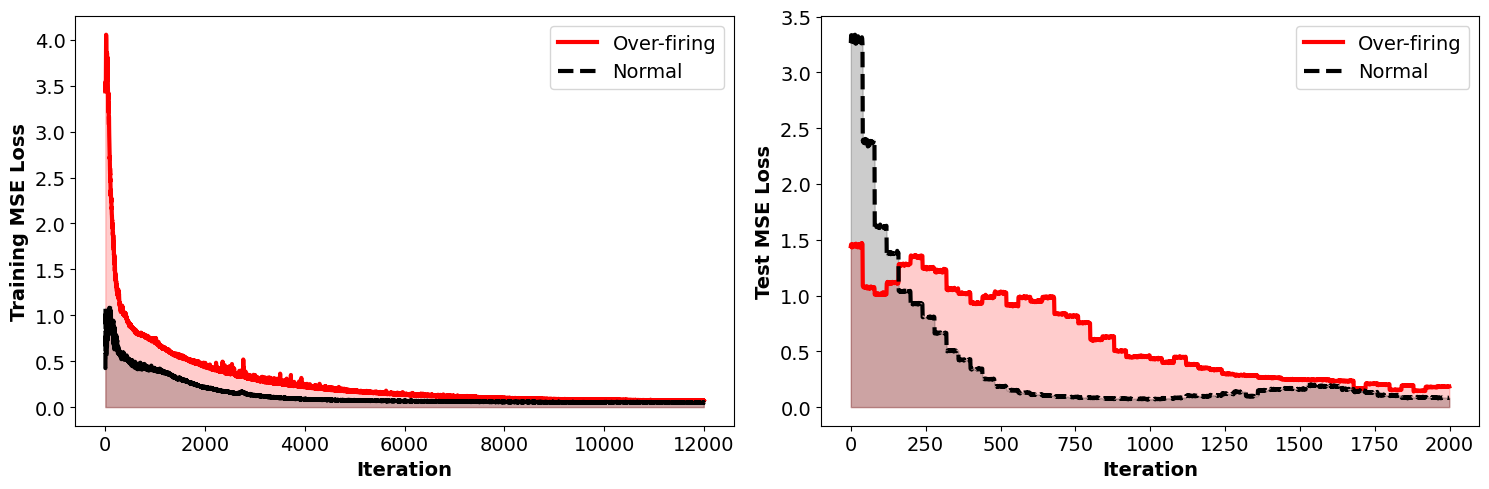

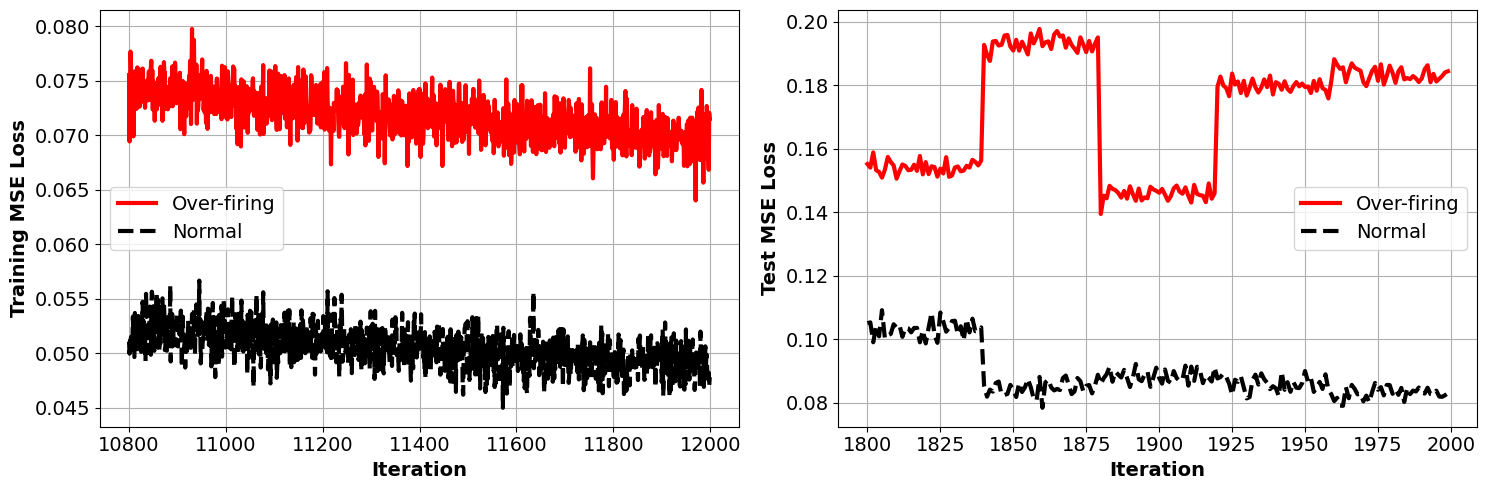

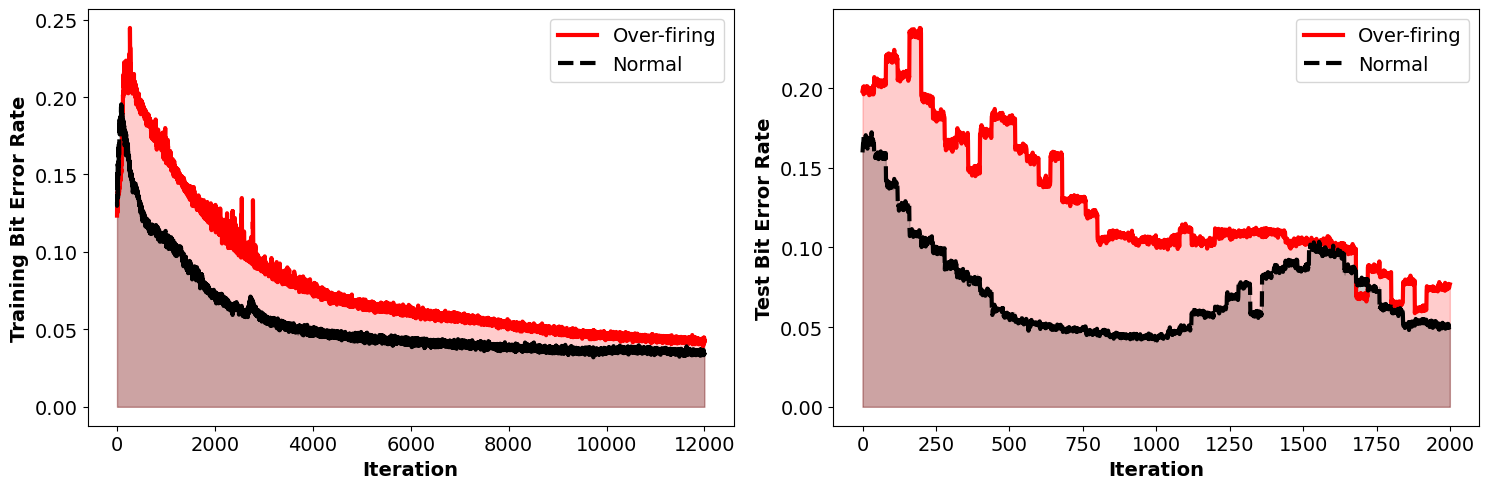

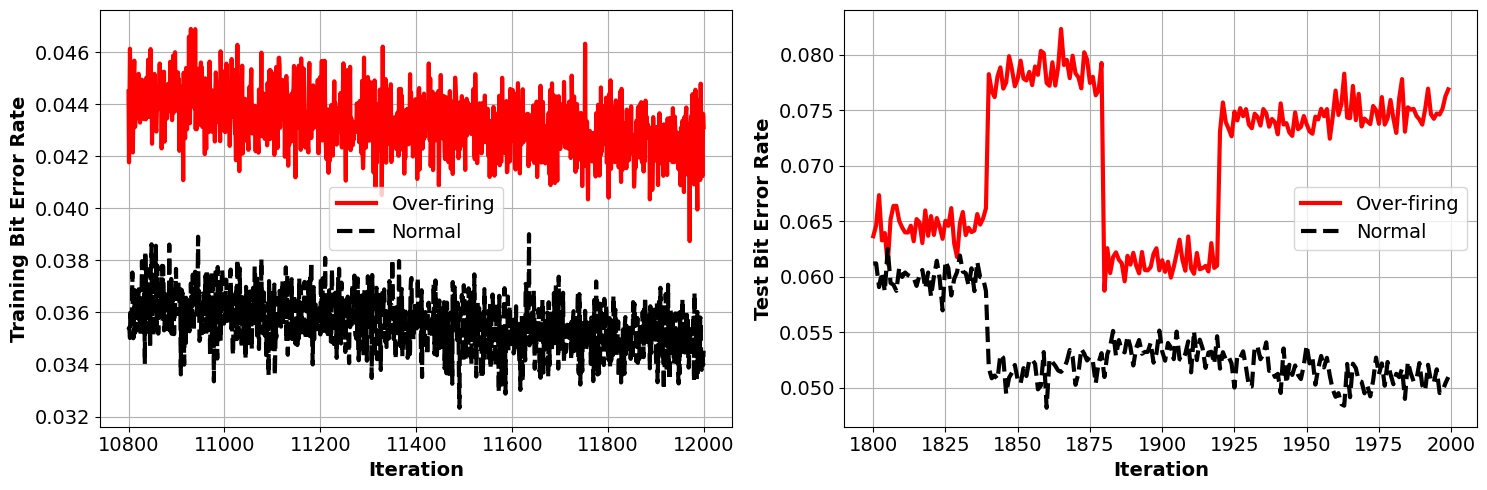

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional color palette
colors = ["#FF0000", "#000000"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 14

# Plot AUC for training loss in the first subplot (ax1)
ax1.plot(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing",  linewidth=3)
ax1.plot(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax1.fill_between(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax1.fill_between(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9, 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(len(train_loss_rec_0_0001)), train_loss_rec_0_0001)
train_auc_0_9 = auc(np.arange(len(train_loss_rec_0_9)), train_loss_rec_0_9)
# ax1.text(0.5, 0.7, "Mutated AUC = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.65, "Normal AUC = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_loss_rec_0_0001)
train_loss_avg_0_9 = np.mean(train_loss_rec_0_9)
# ax1.text(0.5, 0.56, "Avg Loss of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.51, "Avg Loss of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# ax1.set_title("Training set Loss curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training MSE Loss", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels


# print('Mutated AUC = ', str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)


# Plot AUC for test loss in the second subplot (ax2)
ax2.plot(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax2.fill_between(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9, 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(len(test_loss_rec_0_0001)), test_loss_rec_0_0001)
test_auc_0_9 = auc(np.arange(len(test_loss_rec_0_9)), test_loss_rec_0_9)
# ax2.text(0.5, 0.7, "Mutated AUC = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
# ax2.text(0.5, 0.65, "Normal AUC = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_loss_rec_0_0001)
test_loss_avg_0_9 = np.mean(test_loss_rec_0_9)
# ax2.text(0.5, 0.56, "Avg Loss of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
# ax2.text(0.5, 0.51, "Avg Loss of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# ax2.set_title("Test set Loss Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Test MSE Loss", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
# plt.grid(True)
# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("loss_curves.pdf", bbox_inches="tight")
plt.show()




# ///////////////////////////////////////////// Zoomed in //////////////////////
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Calculate the last 10% range for train set
train_range = int(len(train_loss_rec_0_0001) * 0.1)
train_start_idx = len(train_loss_rec_0_0001) - train_range

# Calculate the last 10% range for test set
test_range = int(len(test_loss_rec_0_0001) * 0.1)
test_start_idx = len(test_loss_rec_0_0001) - test_range

# Plot AUC for training loss in the first subplot (ax1)
ax1.plot(np.arange(train_start_idx, len(train_loss_rec_0_0001)), train_loss_rec_0_0001[train_start_idx:], color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax1.plot(np.arange(train_start_idx, len(train_loss_rec_0_9)), train_loss_rec_0_9[train_start_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
train_auc_0_0001 = auc(np.arange(train_start_idx, len(train_loss_rec_0_0001)), train_loss_rec_0_0001[train_start_idx:])
train_auc_0_9 = auc(np.arange(train_start_idx, len(train_loss_rec_0_9)), train_loss_rec_0_9[train_start_idx:])
# ax1.text(0.5, 0.5, "Mutated AUC = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.45, "Normal AUC = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_loss_rec_0_0001[train_start_idx:])
train_loss_avg_0_9 = np.mean(train_loss_rec_0_9[train_start_idx:])
# ax1.text(0.5, 0.38, "Avg Loss of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.33, "Avg Loss of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# ax1.set_title("Training set Loss curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training MSE Loss", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test loss in the second subplot (ax2)
ax2.plot(np.arange(test_start_idx, len(test_loss_rec_0_0001)), test_loss_rec_0_0001[test_start_idx:], color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(test_start_idx, len(test_loss_rec_0_9)), test_loss_rec_0_9[test_start_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
test_auc_0_0001 = auc(np.arange(test_start_idx, len(test_loss_rec_0_0001)), test_loss_rec_0_0001[test_start_idx:])
test_auc_0_9 = auc(np.arange(test_start_idx, len(test_loss_rec_0_9)), test_loss_rec_0_9[test_start_idx:])
# ax2.text(0.5, 0.40, "Mutated AUC = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
# ax2.text(0.5, 0.35, "Normal AUC = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')
ax1.grid(True)

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_loss_rec_0_0001[test_start_idx:])
test_loss_avg_0_9 = np.mean(test_loss_rec_0_9[test_start_idx:])
# ax2.text(0.5, 0.25, "Avg Loss of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
# ax2.text(0.5, 0.20, "Avg Loss of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# ax2.set_title("Test set Loss Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Test MSE Loss", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)
# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("zoomed_loss_curves.pdf", bbox_inches="tight")
plt.show()












# ------------------------------------------------------------- Bit Error Rate -------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax1.plot(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax1.fill_between(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax1.fill_between(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(len(train_ber_rec_0_0001)), train_ber_rec_0_0001)
train_auc_0_9 = auc(np.arange(len(train_ber_rec_0_9)), train_ber_rec_0_9)
# ax1.text(0.5, 0.7, "Mutated BER = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.65, "Normal BER = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_ber_rec_0_0001)
train_loss_avg_0_9 = np.mean(train_ber_rec_0_9)
# ax1.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.51, "Avg BER of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# ax1.set_title("Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax2.fill_between(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(len(test_ber_rec_0_0001)), test_ber_rec_0_0001)
test_auc_0_9 = auc(np.arange(len(test_ber_rec_0_9)), test_ber_rec_0_9)
# ax2.text(0.63, 0.7, "Mutated AUC of BER = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
# ax2.text(0.63, 0.65, "Normal AUC of BER = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_ber_rec_0_0001)
test_loss_avg_0_9 = np.mean(test_ber_rec_0_9)
# ax2.text(0.63, 0.56, "Avg BER of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
# ax2.text(0.63, 0.51, "Avg BER of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# ax2.set_title("Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Test Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
# plt.grid(True)

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("ber_curves.pdf", bbox_inches="tight")
plt.show()


# ///////////////////////////////////////////// Zoomed in BER ///////////////////////////////////

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Calculate the index corresponding to the last 10% of iterations
train_last_10_percent_idx = int(0.9 * len(train_ber_rec_0_0001))
test_last_10_percent_idx = int(0.9 * len(test_ber_rec_0_0001))

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:], color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax1.plot(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
# ax1.fill_between(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax1.fill_between(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
train_auc_0_0001 = auc(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_0001)), train_ber_rec_0_0001[train_last_10_percent_idx:])
train_auc_0_9 = auc(np.arange(train_last_10_percent_idx, len(train_ber_rec_0_9)), train_ber_rec_0_9[train_last_10_percent_idx:])
# ax1.text(0.5, 0.55, "Mutated BER = " + str(round(train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.51, "Normal BER = " + str(round(train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
train_loss_avg_0_0001 = np.mean(train_ber_rec_0_0001[train_last_10_percent_idx:])
train_loss_avg_0_9 = np.mean(train_ber_rec_0_9[train_last_10_percent_idx:])
# ax1.text(0.5, 0.45, "Avg BER of Mutated = " + str(round(train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size)
# ax1.text(0.5, 0.41, "Avg BER of Normal = " + str(round(train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#FF0000')

# ax1.set_title("Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels
ax1.grid(True)

# Calculate the index corresponding to the last 10% of iterations for the test set
test_last_10_percent_idx = int(0.9 * len(test_ber_rec_0_0001))

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:], color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
# ax2.fill_between(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax2.fill_between(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
test_auc_0_0001 = auc(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_0001)), test_ber_rec_0_0001[test_last_10_percent_idx:])
test_auc_0_9 = auc(np.arange(test_last_10_percent_idx, len(test_ber_rec_0_9)), test_ber_rec_0_9[test_last_10_percent_idx:])
# ax2.text(0.63, 0.55, "Mutated AUC of BER = " + str(round(test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size)
# ax2.text(0.63, 0.51, "Normal AUC of BER = " + str(round(test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# Display average loss values on the plot
test_loss_avg_0_0001 = np.mean(test_ber_rec_0_0001[test_last_10_percent_idx:])
test_loss_avg_0_9 = np.mean(test_ber_rec_0_9[test_last_10_percent_idx:])
# ax2.text(0.63, 0.45, "Avg BER of Mutated = " + str(round(test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#000000')
# ax2.text(0.63, 0.41, "Avg BER of Normal = " + str(round(test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#FF0000')

# ax2.set_title("Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Test Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("zoomed_ber_curves.pdf", bbox_inches="tight")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["#264653", "#e76f51"]   #  Mutated , Normal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations
font_size = 14

# Plot AUC for training loss in the first subplot (ax1)
ax1.plot(np.arange(len(n_train_loss_rec_0_0001)), n_train_loss_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing")  # Updated variable names
ax1.plot(np.arange(len(n_train_loss_rec_0_9)), n_train_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal")  # Updated variable names
ax1.fill_between(np.arange(len(n_train_loss_rec_0_0001)), n_train_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])  # Updated variable names
ax1.fill_between(np.arange(len(n_train_loss_rec_0_9)), n_train_loss_rec_0_9, 0, alpha=0.2, color=colors[1])  # Updated variable names
n_train_auc_0_0001 = auc(np.arange(len(n_train_loss_rec_0_0001)), n_train_loss_rec_0_0001)  # Updated variable names
n_train_auc_0_9 = auc(np.arange(len(n_train_loss_rec_0_9)), n_train_loss_rec_0_9)  # Updated variable names
ax1.text(0.5, 0.7, "Mutated AUC = " + str(round(n_train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.65, "Normal AUC = " + str(round(n_train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_train_loss_avg_0_0001 = np.mean(n_train_loss_rec_0_0001)  # Updated variable names
n_train_loss_avg_0_9 = np.mean(n_train_loss_rec_0_9)  # Updated variable names
ax1.text(0.5, 0.56, "Avg Loss of Mutated = " + str(round(n_train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.51, "Avg Loss of Normal = " + str(round(n_train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

ax1.set_title("Noisy Training set Loss curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training Loss", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test loss in the second subplot (ax2)
ax2.plot(np.arange(len(n_test_loss_rec_0_0001)), n_test_loss_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(len(n_test_loss_rec_0_9)), n_test_loss_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax2.fill_between(np.arange(len(n_test_loss_rec_0_0001)), n_test_loss_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(n_test_loss_rec_0_9)), n_test_loss_rec_0_9, 0, alpha=0.2, color=colors[1])
n_test_auc_0_0001 = auc(np.arange(len(n_test_loss_rec_0_0001)), n_test_loss_rec_0_0001)
n_test_auc_0_9 = auc(np.arange(len(n_test_loss_rec_0_9)), n_test_loss_rec_0_9)
# ax2.text(0.5, 0.7, "Noisy Mutated AUC = " + str(round(n_test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.65, "Noisy Normal AUC = " + str(round(n_test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_test_loss_avg_0_0001 = np.mean(n_test_loss_rec_0_0001)  # Updated variable names
n_test_loss_avg_0_9 = np.mean(n_test_loss_rec_0_9)  # Updated variable names
# ax2.text(0.5, 0.56, "Noisy Avg Loss of Mutated = " + str(round(n_test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.51, "Noisy Avg Loss of Normal = " + str(round(n_test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

ax2.set_title("Noisy Test set Loss Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Mean Squared Error (MSE) Loss", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("Noisy_loss_curves.pdf", bbox_inches="tight")
plt.show()

# ///////////////////////////////////////////// Zoomed in //////////////////////
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Calculate the last 10% range for train set
n_train_range = int(len(n_train_loss_rec_0_0001) * 0.1)
n_train_start_idx = len(n_train_loss_rec_0_0001) - n_train_range

# Calculate the last 10% range for test set
n_test_range = int(len(n_test_loss_rec_0_0001) * 0.1)
n_test_start_idx = len(n_test_loss_rec_0_0001) - n_test_range

# Plot AUC for training loss in the first subplot (ax1)
ax1.plot(np.arange(n_train_start_idx, len(n_train_loss_rec_0_0001)), n_train_loss_rec_0_0001[n_train_start_idx:], color=colors[0], linestyle='-', label="Noisy Over-firing Train set AUC", linewidth=3)  # Updated variable names
ax1.plot(np.arange(n_train_start_idx, len(n_train_loss_rec_0_9)), n_train_loss_rec_0_9[n_train_start_idx:], color=colors[1], linestyle='--', label="Noisy Normal Train set AUC", linewidth=3)  # Updated variable names
n_train_auc_0_0001 = auc(np.arange(n_train_start_idx, len(n_train_loss_rec_0_0001)), n_train_loss_rec_0_0001[n_train_start_idx:])  # Updated variable names
n_train_auc_0_9 = auc(np.arange(n_train_start_idx, len(n_train_loss_rec_0_9)), n_train_loss_rec_0_9[n_train_start_idx:])  # Updated variable names
ax1.text(0.5, 0.5, "Noisy Over-firing AUC = " + str(round(n_train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.45, "Noisy Normal AUC = " + str(round(n_train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_train_loss_avg_0_0001 = np.mean(n_train_loss_rec_0_0001[n_train_start_idx:])  # Updated variable names
n_train_loss_avg_0_9 = np.mean(n_train_loss_rec_0_9[n_train_start_idx:])  # Updated variable names
ax1.text(0.5, 0.38, "Noisy Avg Loss of Over-firing = " + str(round(n_train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.33, "Noisy Avg Loss of Normal = " + str(round(n_train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

ax1.set_title("Zoomed in Noisy Training set Loss curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Training Loss", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test loss in the second subplot (ax2)
ax2.plot(np.arange(n_test_start_idx, len(n_test_loss_rec_0_0001)), n_test_loss_rec_0_0001[n_test_start_idx:], color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(n_test_start_idx, len(n_test_loss_rec_0_9)), n_test_loss_rec_0_9[n_test_start_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
n_test_auc_0_0001 = auc(np.arange(n_test_start_idx, len(n_test_loss_rec_0_0001)), n_test_loss_rec_0_0001[n_test_start_idx:])
n_test_auc_0_9 = auc(np.arange(n_test_start_idx, len(n_test_loss_rec_0_9)), n_test_loss_rec_0_9[n_test_start_idx:])
# ax2.text(0.5, 0.6, "Mutated AUC = " + str(round(n_test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.55, "Normal AUC = " + str(round(n_test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_test_loss_avg_0_0001 = np.mean(n_test_loss_rec_0_0001[n_test_start_idx:])  # Updated variable names
n_test_loss_avg_0_9 = np.mean(n_test_loss_rec_0_9[n_test_start_idx:])  # Updated variable names
# ax2.text(0.5, 0.45, "Avg Loss of Mutated = " + str(round(n_test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.4, "Avg Loss of Normal = " + str(round(n_test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')
ax2.set_title("Zoomed in Noisy Test set Loss Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Mean Squared Error (MSE) Loss", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("Zoomed in Noisy loss_curves.pdf", bbox_inches="tight")
plt.show()








# ------------------------------------------------------------- Bit Error Rate -------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax1.plot(np.arange(len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax1.fill_between(np.arange(len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax1.fill_between(np.arange(len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
n_train_auc_0_0001 = auc(np.arange(len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001)
n_train_auc_0_9 = auc(np.arange(len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9)
ax1.text(0.5, 0.7, "Over-firing AUC = " + str(round(n_train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.65, "Normal AUC = " + str(round(n_train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_train_loss_avg_0_0001 = np.mean(n_train_ber_rec_0_0001)
n_train_loss_avg_0_9 = np.mean(n_train_ber_rec_0_9)
ax1.text(0.5, 0.56, "Avg BER of Over-firing = " + str(round(n_train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
ax1.text(0.5, 0.51, "Avg BER of Normal = " + str(round(n_train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# ax1.set_title("Noisy Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001, color=colors[0], linestyle='-', label="Over-firing", linewidth=3)
ax2.plot(np.arange(len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9, color=colors[1], linestyle='--', label="Normal", linewidth=3)
ax2.fill_between(np.arange(len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001, 0, alpha=0.2, color=colors[0])
ax2.fill_between(np.arange(len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9, 0, alpha=0.2, color=colors[1])
n_test_auc_0_0001 = auc(np.arange(len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001)
n_test_auc_0_9 = auc(np.arange(len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9)
# ax2.text(0.5, 0.7, "Mutated AUC = " + str(round(n_test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.65, "Normal AUC = " + str(round(n_test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_test_loss_avg_0_0001 = np.mean(n_test_ber_rec_0_0001)
n_test_loss_avg_0_9 = np.mean(n_test_ber_rec_0_9)
# ax2.text(0.5, 0.56, "Avg BER of Mutated = " + str(round(n_test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.5, 0.51, "Avg BER of Normal = " + str(round(n_test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# ////////////////////////////// last error ////////////////////////////////////
# # Display last loss values on the plot
# last_n_test_ber_0_0001 = n_test_ber_rec_0_0001[-1]
# last_n_test_ber_0_9 = n_test_ber_rec_0_9[-1]

# # Annotate last loss values on the plot
# ax2.annotate(f'Last BER of Mutated = {round(last_n_test_ber_0_0001, 4)}',
#              xy=(len(n_test_ber_rec_0_0001)-1, last_n_test_ber_0_0001),
#              xytext=(len(n_test_ber_rec_0_0001)-1, last_n_test_ber_0_0001 + 0.02),
#              fontsize=font_size, color=colors[0],
#              arrowprops=dict(facecolor=colors[0], arrowstyle="->", lw=1.5),
#              ha='center')
# ax2.annotate(f'Last BER of Normal = {round(last_n_test_ber_0_9, 4)}',
#              xy=(len(n_test_ber_rec_0_9)-1, last_n_test_ber_0_9),
#              xytext=(len(n_test_ber_rec_0_9)-1, last_n_test_ber_0_9 - 0.02),
#              fontsize=font_size, color=colors[1],
#              arrowprops=dict(facecolor=colors[1], arrowstyle="->", lw=1.5),
#              ha='center')
# ///////////////////////////////////////////////////////////////////////////////




# ax2.set_title("Noisy Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)
# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("Noisy_BER_curves.pdf", bbox_inches="tight")
plt.show()


# ///////////////////////////////////////////// Zoomed in BER ///////////////////////////////////

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Adjust the figure size
# Increase font size for titles, labels, and annotations

# Calculate the index corresponding to the last 10% of iterations
n_train_last_10_percent_idx = int(0.9 * len(n_train_ber_rec_0_0001))
n_test_last_10_percent_idx = int(0.9 * len(n_test_ber_rec_0_0001))

# Plot AUC for training BER in the first subplot (ax1)
ax1.plot(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001[n_train_last_10_percent_idx:], color=colors[0], linestyle='-', label="Noisy Over-firing Train set BER", linewidth=3)
ax1.plot(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9[n_train_last_10_percent_idx:], color=colors[1], linestyle='--', label="Noisy Normal Train set BER", linewidth=3)
# ax1.fill_between(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001[n_train_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax1.fill_between(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9[n_train_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
n_train_auc_0_0001 = auc(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_0001)), n_train_ber_rec_0_0001[n_train_last_10_percent_idx:])
n_train_auc_0_9 = auc(np.arange(n_train_last_10_percent_idx, len(n_train_ber_rec_0_9)), n_train_ber_rec_0_9[n_train_last_10_percent_idx:])
# ax1.text(0.5, 0.15, "Noisy_Mutated BER = " + str(round(n_train_auc_0_0001, 1)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
# ax1.text(0.5, 0.11, "Noisy_Normal BER = " + str(round(n_train_auc_0_9, 1)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_train_loss_avg_0_0001 = np.mean(n_train_ber_rec_0_0001[n_train_last_10_percent_idx:])
n_train_loss_avg_0_9 = np.mean(n_train_ber_rec_0_9[n_train_last_10_percent_idx:])
# ax1.text(0.5, 0.05, "Avg BER of Mutated_Noisy = " + str(round(n_train_loss_avg_0_0001, 4)), transform=ax1.transAxes, fontsize=font_size, color='#264653')
# ax1.text(0.5, 0.01, "Avg BER of Normal_Noisy = " + str(round(n_train_loss_avg_0_9, 4)), transform=ax1.transAxes, fontsize=font_size, color='#e76f51')

# ax1.set_title("Zoomed in Noisy Training set BER curve", fontweight="bold", fontsize=font_size)
ax1.legend(fontsize=font_size)
ax1.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax1.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax1.tick_params(labelsize=font_size)  # Increase font size for tick labels

# Calculate the index corresponding to the last 10% of iterations for the test set
n_test_last_10_percent_idx = int(0.9 * len(n_test_ber_rec_0_0001))

# Plot AUC for test BER in the second subplot (ax2)
ax2.plot(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001[n_test_last_10_percent_idx:], color=colors[0], linestyle='-', label="Mutated", linewidth=3)
ax2.plot(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9[n_test_last_10_percent_idx:], color=colors[1], linestyle='--', label="Normal", linewidth=3)
# ax2.fill_between(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001[n_test_last_10_percent_idx:], 0, alpha=0.2, color=colors[0])
# ax2.fill_between(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9[n_test_last_10_percent_idx:], 0, alpha=0.2, color=colors[1])
n_test_auc_0_0001 = auc(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_0001)), n_test_ber_rec_0_0001[n_test_last_10_percent_idx:])
n_test_auc_0_9 = auc(np.arange(n_test_last_10_percent_idx, len(n_test_ber_rec_0_9)), n_test_ber_rec_0_9[n_test_last_10_percent_idx:])
# ax2.text(0.63, 0.25, "Mutated AUC = " + str(round(n_test_auc_0_0001, 1)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.63, 0.21, "Normal AUC = " + str(round(n_test_auc_0_9, 1)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# Display average loss values on the plot
n_test_loss_avg_0_0001 = np.mean(n_test_ber_rec_0_0001[n_test_last_10_percent_idx:])
n_test_loss_avg_0_9 = np.mean(n_test_ber_rec_0_9[n_test_last_10_percent_idx:])
# ax2.text(0.63, 0.15, "Avg BER of Mutated = " + str(round(n_test_loss_avg_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#264653')
# ax2.text(0.63, 0.11, "Avg BER of Normal = " + str(round(n_test_loss_avg_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')
# ////////////////////////////// last error ////////////////////////////////////
# # Display last loss values on the plot for n_test_ber_rec_0_0001
# last_n_test_ber_0_0001 = n_test_ber_rec_0_0001[-1]
# ax2.text(0.63, 0.06, "Last BER of Mutated = " + str(round(last_n_test_ber_0_0001, 4)), transform=ax2.transAxes, fontsize=font_size, color='#264653')

# # Display last loss values on the plot for n_test_ber_rec_0_9
# last_n_test_ber_0_9 = n_test_ber_rec_0_9[-1]
# ax2.text(0.63, 0.02, "Last BER of Normal = " + str(round(last_n_test_ber_0_9, 4)), transform=ax2.transAxes, fontsize=font_size, color='#e76f51')

# ///////////////////////////////////////////////////////////////////////////////




# ax2.set_title("Zoomed in Noisy Test set BER Curve", fontweight="bold", fontsize=font_size)
ax2.legend(fontsize=font_size)
ax2.set_xlabel("Iteration", fontweight="bold", fontsize=font_size)
ax2.set_ylabel("Bit Error Rate", fontweight="bold", fontsize=font_size)
ax2.tick_params(labelsize=font_size)  # Increase font size for tick labels

plt.tight_layout()
plt.grid(True)

# Save the figure as a vector graphic (e.g., PDF) for publication
plt.savefig("Zoomed_Noisy_BER_curves.pdf", bbox_inches="tight")
plt.show()


